In [1]:
import cv2
import os
import shutil
import numpy as np
import pyautogui
import json

<h1>HoloControl System</h1>

<h2>Hand Detection Model<h2>

In [2]:
with open('dataset1/training_xyz.json') as f:
    xyz = np.array(json.load(f))
    # (N, 21, 3)

with open('dataset1/training_K.json') as f:
    K = np.array(json.load(f))
    # (N, 3, 3)

keypoints_dict = {}

for idx in range(len(xyz)):
    joints_3d = xyz[idx] # (21, 3)
    cam_K = K[idx]       # (3, 3)

    uv = []
    for point in joints_3d:
        x, y, z = point
        px = (cam_K[0][0] * x + cam_K[0][2] * z) / z
        py = (cam_K[1][1] * y + cam_K[1][2] * z) / z
        uv.append([px, py])

    uv = np.array(uv)
    
    uv[:, 0] = uv[:, 0] / 224
    uv[:, 1] = uv[:, 1] / 224
    uv = uv * 128
    keypoints_dict[f"{idx:08d}.jpg"] = uv.flatten().tolist()

In [3]:
import os
print("Number of images:", len(os.listdir('dataset1/training/rgb')))
print("Number of keypoints:", len(xyz))
print("Number of K:", len(K))
import torch
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Number of images: 130240
Number of keypoints: 32560
Number of K: 32560
Device: cuda


<h2>Dataset and Model Training<h2>

In [4]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Dataset Preparation
class HandPoseDataset(Dataset):
    def __init__(self, image_dir, keypoints_dict, image_list):
        self.image_dir = image_dir
        self.keypoints_dict = keypoints_dict
        self.image_list = image_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (C, H, W)
        keypoints = np.array(self.keypoints_dict[img_name], dtype=np.float32)
        keypoints /= 128.0
        return torch.tensor(img, dtype=torch.float32), torch.tensor(keypoints, dtype=torch.float32)

images = [img for img in sorted(os.listdir('dataset1/training/rgb')) if img.endswith('.jpg') and img in keypoints_dict]
print("Total images:", len(images))
print("Total keypoints:", len(keypoints_dict))

dataset = HandPoseDataset('dataset1/training/rgb', keypoints_dict, images)
data_size = len(dataset)
train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size

train_dataset, mix_dataset = random_split(dataset, [train_size, val_size+test_size])
test_dataset, val_dataset = random_split(mix_dataset, [test_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(len(dataset[0][0]))
print(dataset[0][1])


# CNN Model 
class HandPoseCNN(nn.Module):
    def __init__(self):
        super(HandPoseCNN, self).__init__()
        self.features = nn.Sequential(
            # nn.Conv2d(3, 32, kernel_size=3),     # 126x126
            # nn.ReLU(),
            # nn.MaxPool2d(2),                     # 63x63
            # nn.Conv2d(32, 64, kernel_size=3),    # 61x61
            # nn.ReLU(),
            # nn.MaxPool2d(2),                     # 30x30
            # nn.Conv2d(64, 32, kernel_size=3),    # 28x28
            # nn.ReLU(),
            # nn.Flatten()
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # 128, 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 64, 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 32, 16
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 16, 8
            nn.Flatten(),
            nn.Linear(256*8*8, 512), nn.ReLU(),
            nn.Linear(512, 42)
        )

        # Dynamically computing flattened size
    #     self.flattened_size = self._get_flattened_size()
    #     self.fc1 = nn.Linear(self.flattened_size, 512)
    #     self.fc2 = nn.Linear(512, 42)

    # def _get_flattened_size(self):
    #     with torch.no_grad():
    #         dummy = torch.zeros(1, 3, 128, 128)
    #         out = self.features(dummy)
    #         return out.view(1, -1).shape[1]

    def forward(self, x):
        # x = self.features(x)
        # x = self.fc1(x)
        # x = self.fc2(x)

        return self.features(x)

# Training CNN Model
model = HandPoseCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# if os.path.exists("best_hand_model.pth"):
#     model.load_state_dict(torch.load("best_hand_model.pth"))
#     print("✅ Loaded saved model!")

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, keypoints in train_loader:
        imgs, keypoints = imgs.to(device), keypoints.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, keypoints)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, keypoints in val_loader:
            imgs, keypoints = imgs.to(device), keypoints.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, keypoints)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_hand_model.pth")
        print("✅ Saved new best model.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping.")
            break


Total images: 32560
Total keypoints: 32560
3
tensor([0.5870, 0.4175, 0.5145, 0.3753, 0.4727, 0.3776, 0.4219, 0.4164, 0.3526,
        0.4645, 0.4546, 0.4703, 0.4115, 0.4994, 0.3769, 0.5178, 0.3526, 0.5465,
        0.4338, 0.5319, 0.3867, 0.5725, 0.3501, 0.6014, 0.3297, 0.6432, 0.4266,
        0.5675, 0.3813, 0.5981, 0.3402, 0.6290, 0.3092, 0.6603, 0.4168, 0.5866,
        0.3776, 0.6251, 0.3431, 0.6572, 0.3219, 0.6954])
Epoch [1/20] | Train Loss: 0.0049 | Val Loss: 0.0029
✅ Saved new best model.
Epoch [2/20] | Train Loss: 0.0025 | Val Loss: 0.0023
✅ Saved new best model.
Epoch [3/20] | Train Loss: 0.0021 | Val Loss: 0.0020
✅ Saved new best model.
Epoch [4/20] | Train Loss: 0.0018 | Val Loss: 0.0018
✅ Saved new best model.
Epoch [5/20] | Train Loss: 0.0017 | Val Loss: 0.0017
✅ Saved new best model.
Epoch [6/20] | Train Loss: 0.0015 | Val Loss: 0.0016
✅ Saved new best model.
Epoch [7/20] | Train Loss: 0.0014 | Val Loss: 0.0014
✅ Saved new best model.
Epoch [8/20] | Train Loss: 0.0013 | Val

<h2>Showing Dataset</h2>

Image:  tensor([[[0.2706, 0.2745, 0.2745,  ..., 0.9647, 0.9882, 0.9961],
         [0.2745, 0.2745, 0.2784,  ..., 0.9647, 0.9882, 1.0000],
         [0.2667, 0.2627, 0.2667,  ..., 0.9686, 0.9804, 1.0000],
         ...,
         [0.0039, 0.1412, 0.1725,  ..., 0.2902, 0.2902, 0.2039],
         [0.0000, 0.1059, 0.1451,  ..., 0.3059, 0.3137, 0.2078],
         [0.0118, 0.0000, 0.0000,  ..., 0.2000, 0.1961, 0.1412]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.9490, 0.9804, 0.9922],
         [0.4784, 0.4745, 0.4784,  ..., 0.9529, 0.9843, 0.9922],
         [0.4745, 0.4706, 0.4745,  ..., 0.9529, 0.9765, 0.9922],
         ...,
         [0.0039, 0.2157, 0.2980,  ..., 0.4392, 0.4314, 0.3333],
         [0.0000, 0.1647, 0.2314,  ..., 0.4392, 0.4431, 0.3255],
         [0.0000, 0.0078, 0.0118,  ..., 0.3098, 0.2980, 0.2353]],

        [[0.3882, 0.3961, 0.3961,  ..., 0.9922, 1.0000, 1.0000],
         [0.3882, 0.3961, 0.4000,  ..., 0.9922, 1.0000, 1.0000],
         [0.3882, 0.3922, 0.3961,  ..., 0.9961, 0.

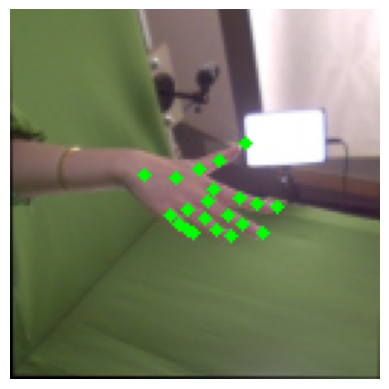

In [5]:
import matplotlib.pyplot as plt

def visualize_keypoints(img_tensor, keypoints):
    # Converting tensor to numpy and change shape to (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy() * 255 
    img = img.astype(np.uint8)
    h, w = img.shape[:2]

    for i, (x, y) in enumerate(keypoints):
        px = int(x * w)
        py = int(y * h)
        cv2.circle(img, (px, py), 2, (0, 255, 0), -1)
        # cv2.putText(img, str(i), (px, py), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

img_tensor, keypoints = dataset[1]
keypoints = keypoints.view(-1, 2)
print("Image: ", img_tensor)
print("Keypoints: ", keypoints)

visualize_keypoints(img_tensor, keypoints)

<h2>Test Loss</h2>

In [6]:
# Test Loss
model = HandPoseCNN()  # same architecture
model.load_state_dict(torch.load("best_hand_model.pth"))
model.to(device)
model.eval()

test_loss = 0.0
total_samples = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs) # Forward Pass

        loss = criterion(outputs, targets) 

        batch_size = inputs.size(0)
        test_loss += loss.item() * batch_size
        total_samples += batch_size

avg_test_loss = test_loss / total_samples
print(f"Test Loss; {avg_test_loss:.4f}")

/tmp/ipykernel_578/2535535484.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_hand_model.pth"))


Test Loss; 0.0010


<h2>Predicting on an Image</h2>

/tmp/ipykernel_578/2917509969.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_hand_model.pth"))


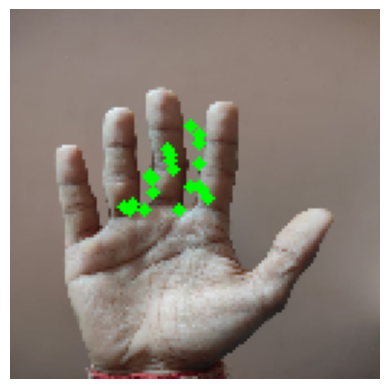

In [7]:
model = HandPoseCNN()  # same architecture
model.load_state_dict(torch.load("best_hand_model.pth"))
model.to(device)
model.eval()  # Set to evaluation mode

import matplotlib.pyplot as plt

def predict_single_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
    # img_tensor = torch.tensor(np.transpose(img_normalized, (2, 0, 1)), dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        prediction = output.squeeze(0).cpu().view(-1, 2).numpy()  # (21, 2)

    return img_tensor.squeeze(0).cpu(), prediction

def visualize_keypoints(img_tensor, keypoints):
    # Convert tensor to numpy and change shape to (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy() * 255  # back to 0-255
    img = img.astype(np.uint8)
    h, w = img.shape[:2]
    for i, (x, y) in enumerate(keypoints):
        px = int(x * w)
        py = int(y * h)
        cv2.circle(img, (px, py), 2, (0, 255, 0), -1)
        # cv2.putText(img, str(i), (px, py), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path = "./hand.jpeg"
img, keypoints = predict_single_image(image_path, model)
visualize_keypoints(img, keypoints)

# dummy_input = torch.randn(1, 3, 128, 128).to(device)
# torch.onnx.export(model, dummy_input, "handpose_model.onnx", input_names=["input"], output_names=["keypoints"])


<h2>Hand Detection real time using mediapipe</h2>

In [9]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

cap = cv2.VideoCapture(0)

with mp_hands.Hands(max_num_hands = 2, min_detection_confidence = 0.7, min_tracking_confidence = 0.6) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break
          
        image = cv2.flip(image, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        cv2.imshow("HoloControl - Hand Detection", image)

        if cv2.waitKey(1) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1751916855.941797     719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751916855.963644     713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Qt: Session management error: Could not open network socket
W0000 00:00:1751917435.102528     710 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


<h2>Dataset preparation for Hand Sign Detection</h2>

In [10]:
import os
import shutil

main = 'leapGestRecog'
final = 'dataset'

for user_folder in os.listdir(main):
    user_path = os.path.join(main, user_folder)
    
    if not os.path.isdir(user_path):
        continue

    for gesture_folder in os.listdir(user_path):
        gesture_path = os.path.join(user_path, gesture_folder)
        gesture_name = gesture_folder.split("_")[1]
        dest_folder = os.path.join(final, gesture_name)
        os.makedirs(dest_folder, exist_ok=True)
        
        count = 0
        for img in os.listdir(gesture_path):
            src = os.path.join(gesture_path, img)
            new_name = f"{user_folder}_{gesture_name}_{str(count).zfill(3)}.png"
            dst = os.path.join(dest_folder, new_name)
            shutil.copy(src, dst)
            count += 1

FileNotFoundError: [Errno 2] No such file or directory: 'leapGestRecog'